# Utils

> General SAX utilities

In [2]:
import matplotlib.pyplot as plt
from fastcore.test import test_eq
from pytest import raises

import os, sys; sys.stderr = open(os.devnull, "w")

In [3]:
from __future__ import annotations

import inspect
import re
import warnings
from functools import lru_cache, partial, wraps
from hashlib import md5
from typing import Any, Callable, Dict, Iterable, Iterator, Tuple, Union, cast, overload

import numpy as np
import orjson
from natsort import natsorted
from sax.typing_ import (
    Array,
    ComplexFloat,
    Float,
    Model,
    ModelFactory,
    SCoo,
    SDense,
    SDict,
    Settings,
    SType,
    is_mixedmode,
    is_model,
    is_model_factory,
    is_scoo,
    is_sdense,
    is_sdict,
)

try:
    import jax
    import jax.numpy as jnp
    import jax.scipy as jsp
    import jax.scipy.linalg
    JAX_AVAILABLE = True
except ImportError:
    import numpy as jnp
    import scipy as jsp
    import scipy.linalg
    JAX_AVAILABLE = False

:::{eval-rst}
.. autofunction:: sax.utils.block_diag
:::


In [4]:
def block_diag(*arrs: Array) -> Array:
    """create block diagonal matrix with arbitrary batch dimensions """
    batch_shape = arrs[0].shape[:-2]
    
    B = jnp.prod(jnp.asarray(batch_shape, dtype=int))
    
    N = 0
    for arr in arrs:
        if batch_shape != arr.shape[:-2]:
            raise ValueError("batch dimensions for given arrays don't match.")
        m, n = arr.shape[-2:]
        if m != n:
            raise ValueError("given arrays are not square.")
        N += n
    
    arrs = [arr.reshape(-1, arr.shape[-2], arr.shape[-1]) for arr in arrs]

    if JAX_AVAILABLE:
        batch_block_diag = jax.vmap(jsp.linalg.block_diag, in_axes=0, out_axes=0)
        block_diag = batch_block_diag(*arrs)
    else:
        arrs = [jsp.linalg.block_diag(*[arr[i] for arr in arrs]) for i in range(B)]
        block_diag = jnp.stack(arrs, 0)
        
    return block_diag.reshape(*batch_shape, N, N)

In [5]:
arr1 = 1 * jnp.ones((1, 2, 2))
arr2 = 2 * jnp.ones((1, 3, 3))

test_eq(
    block_diag(arr1, arr2),
    [[[1.0, 1.0, 0.0, 0.0, 0.0],
      [1.0, 1.0, 0.0, 0.0, 0.0],
      [0.0, 0.0, 2.0, 2.0, 2.0],
      [0.0, 0.0, 2.0, 2.0, 2.0],
      [0.0, 0.0, 2.0, 2.0, 2.0]]]
)

:::{eval-rst}
.. autofunction:: sax.utils.clean_string
:::


In [6]:

def clean_string(s: str, dot='p', minus='m', other='_') -> str:
    """clean a string such that it is a valid python identifier"""
    original = s
    s = s.strip()
    s = s.replace(".", dot)  # dot
    s = s.replace("-", minus)  # minus
    s = re.sub("[^0-9a-zA-Z]", other, s)
    if s[0] in "0123456789":
        s = "_" + s
    if s != original:
        warnings.warn(f"modified string {original} in an attempt to make valid python identifier: {s}")
    if not s.isidentifier():
        raise ValueError(f"failed to clean string to a valid python identifier: {s}")
    return s

In [7]:
assert clean_string("Hello, string 1.0") == "Hello__string_1p0"

:::{eval-rst}
.. autofunction:: sax.utils.copy_settings
:::


:::{eval-rst}
.. autofunction:: sax.utils.validate_settings
:::


:::{eval-rst}
.. autofunction:: sax.utils.try_float
:::


In [8]:

def copy_settings(settings: Settings) -> Settings:
    """copy a parameter dictionary"""
    return validate_settings(settings)  # validation also copies

def validate_settings(settings: Settings) -> Settings:
    """Validate a parameter dictionary"""
    _settings = {}
    for k, v in settings.items():
        if isinstance(v, dict):
            _settings[k] = validate_settings(v)
        else:
            _settings[k] = try_float(v)
    return _settings

def try_float(f: Any) -> Any:
    """try converting an object to float, return unchanged object on fail"""
    try:
        return jnp.asarray(f, dtype=float)
    except (ValueError, TypeError):
        return f

In [9]:
orig_settings = {"a": 3, "c": jnp.array([9.0, 10.0, 11.0])}
new_settings = copy_settings(orig_settings)

assert orig_settings["a"] == new_settings["a"]
assert jnp.all(orig_settings["c"] == new_settings["c"])
new_settings["a"] = jnp.array(5.0)
assert orig_settings["a"] == 3
assert new_settings["a"] == 5
assert orig_settings["c"] is new_settings["c"]

:::{eval-rst}
.. autofunction:: sax.utils.flatten_dict
:::


In [10]:
def flatten_dict(dic: Dict[str, Any], sep: str = ",") -> Dict[str, Any]:
    """flatten a nested dictionary"""
    return _flatten_dict(dic, sep=sep)


def _flatten_dict(
    dic: Dict[str, Any], sep: str = ",", frozen: bool = False, parent_key: str = ""
) -> Dict[str, Any]:
    items = []
    for k, v in dic.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(
                _flatten_dict(v, sep=sep, frozen=frozen, parent_key=new_key).items()
            )
        else:
            items.append((new_key, v))

    return dict(items)

In [11]:
nested_dict = {
    "a": 3.0,
    "b": {"c": 4.0},
}

flat_dict = flatten_dict(nested_dict, sep=",")
assert flat_dict == {"a": 3.0, "b,c": 4.0}

:::{eval-rst}
.. autofunction:: sax.utils.unflatten_dict
:::


In [12]:

def unflatten_dict(dic, sep=","):
    """unflatten a flattened dictionary """
    
    # from: https://gist.github.com/fmder/494aaa2dd6f8c428cede
    items = dict()

    for k, v in dic.items():
        keys = k.split(sep)
        sub_items = items
        for ki in keys[:-1]:
            if ki in sub_items:
                sub_items = sub_items[ki]
            else:
                sub_items[ki] = dict()
                sub_items = sub_items[ki]

        sub_items[keys[-1]] = v

    return items

In [13]:
assert unflatten_dict(flat_dict, sep=",") == nested_dict

:::{eval-rst}
.. autofunction:: sax.utils.get_ports
:::


In [14]:

def get_ports(S: Union[Model, SType]) -> Tuple[str, ...]:
    """get port names of a model or an stype"""
    if is_model(S):
        return _get_ports_from_model(cast(Model, S))
    elif is_sdict(S):
        ports_set = {p1 for p1, _ in S} | {p2 for _, p2 in S}
        return tuple(natsorted(ports_set))
    elif is_scoo(S) or is_sdense(S):
        *_, ports_map = S
        return tuple(natsorted(ports_map.keys()))
    else:
        raise ValueError("Could not extract ports for given S")
        
@lru_cache(maxsize=4096)  # cache to prevent future tracing
def _get_ports_from_model(model: Model) -> Tuple[str, ...]:
    if JAX_AVAILABLE:
        S: SType = jax.eval_shape(model)
    else:
        warnings.warn("[NO JAX] requesting the ports of a model requires evaluating the model!")
        S = model()
    return get_ports(S)

> Note: if a `Model` function is given in stead of an `SDict`, the function will be traced by JAX to obtain the ports of the resulting `SType`. Although this tracing of the function is 'cheap' in comparison to evaluating the model/circuit. It is not for free!  Use this function sparingly on your large `Model` or `circuit`!

In [15]:
from sax.typing_ import scoo
scoo({("in0", "out0"): 1.0})

(Array([0], dtype=int32),
 Array([1], dtype=int32),
 Array([1.], dtype=float32, weak_type=True),
 {'in0': 0, 'out0': 1})

In [16]:
def coupler(coupling=0.5):
    return {
        ("in0", "out0"): coupling**0.5,
        ("in0", "out1"): 1j*coupling**0.5,
        ("in1", "out0"): 1j*coupling**0.5,
        ("in1", "out1"): coupling**0.5,
    }

model = coupler
assert get_ports(model) == ('in0', 'in1', 'out0', 'out1')

sdict_ = coupler()
assert get_ports(sdict_) == ('in0', 'in1', 'out0', 'out1')

from sax.typing_ import scoo
scoo_ = scoo(sdict_)
assert get_ports(scoo_) == ('in0', 'in1', 'out0', 'out1')

from sax.typing_ import sdense
sdense_ = sdense(sdict_)
assert get_ports(sdense_) == ('in0', 'in1', 'out0', 'out1')

:::{eval-rst}
.. autofunction:: sax.utils.get_port_combinations
:::


In [17]:

def get_port_combinations(S: Union[Model, SType]) -> Tuple[Tuple[str, str], ...]:
    """get port combinations of a model or an stype"""
    
    if is_model(S):
        S = cast(Model, S)
        return _get_port_combinations_from_model(S)
    elif is_sdict(S):
        S = cast(SDict, S)
        return tuple(S.keys())
    elif is_scoo(S):
        Si, Sj, _, pm = cast(SCoo, S)
        rpm = {int(i): str(p) for p, i in pm.items()}
        return tuple(natsorted((rpm[int(i)], rpm[int(j)]) for i, j in zip(Si, Sj)))
    elif is_sdense(S):
        _, pm = cast(SDense, S)
        return tuple(natsorted((p1, p2) for p1 in pm for p2 in pm))
    else:
        raise ValueError("Could not extract ports for given S")
        
@lru_cache(maxsize=4096)  # cache to prevent future tracing
def _get_port_combinations_from_model(model: Model) -> Tuple[Tuple[str, str], ...]:
    if JAX_AVAILABLE:
        S: SType = jax.eval_shape(model)
    else:
        warnings.warn("[NO JAX] requesting the ports of a model requires evaluating the model!")
        S = model()
    return get_port_combinations(S)

> Note: if a `Model` function is given in stead of an `SDict`, the function will be traced by JAX to obtain the port combinations of the resulting `SType`. Although this tracing of the function is 'cheap' in comparison to evaluating the model/circuit. It is not for free!  Use this function sparingly on your large `Model` or `circuit`!

In [18]:
model = coupler
assert get_port_combinations(model) == (("in0", "out0"), ("in0", "out1"), ("in1", "out0"), ("in1", "out1"))

sdict_ = coupler()
assert get_port_combinations(sdict_) == (("in0", "out0"), ("in0", "out1"), ("in1", "out0"), ("in1", "out1"))

from sax.typing_ import scoo
scoo_ = scoo(sdict_)
assert get_port_combinations(scoo_) == (("in0", "out0"), ("in0", "out1"), ("in1", "out0"), ("in1", "out1"))

from sax.typing_ import sdense
sdense_ = sdense(sdict_)
assert get_port_combinations(sdense_) == (("in0", "in0"), ("in0", "in1"), ("in0", "out0"), ("in0", "out1"), 
    ("in1", "in0"), ("in1", "in1"), ("in1", "out0"), ("in1", "out1"), ("out0", "in0"),  ("out0", "in1"), 
    ("out0", "out0"), ("out0", "out1"), ("out1", "in0"), ("out1", "in1"), ("out1", "out0"), ("out1", "out1"))

:::{eval-rst}
.. autofunction:: sax.utils.get_settings
:::


In [19]:
def get_settings(model: Union[Model, ModelFactory]) -> Settings:
    """Get the parameters of a SAX model function"""
    
    signature = inspect.signature(model)

    settings: Settings = {
        k: (v.default if not isinstance(v, dict) else v)
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }

    # make sure an inplace operation of resulting dict does not change the
    # circuit parameters themselves
    return copy_settings(settings)

In [20]:
assert get_settings(coupler) == {'coupling': 0.5}

:::{eval-rst}
.. autofunction:: sax.utils.grouped_interp
:::


In [21]:
def grouped_interp(wl: Float, wls: Float, phis: Float) -> Float:
    """Grouped phase interpolation"""
    if not JAX_AVAILABLE:
        raise NotImplementedError("[NO JAX] grouped_interp function not implemented when JAX not available. Please install JAX.")
        
    @partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
    @jax.jit
    def _grouped_interp(
        wl: Array,  # 0D array (not-vmapped) ; 1D array (vmapped)
        wls: Array,  # 1D array
        phis: Array,  # 1D array
    ) -> Array:
        dphi_dwl = (phis[1::2] - phis[::2]) / (wls[1::2] - wls[::2])
        phis = phis[::2]
        wls = wls[::2]
        dwl = (wls[1:] - wls[:-1]).mean(0, keepdims=True)

        t = (wl - wls + 1e-5 * dwl) / dwl  # small offset to ensure no values are zero
        t = jnp.where(jnp.abs(t) < 1, t, 0)
        m0 = jnp.where(t > 0, size=1)[0]
        m1 = jnp.where(t < 0, size=1)[0]
        t = t[m0]
        wl0 = wls[m0]
        wl1 = wls[m1]
        phi0 = phis[m0]
        phi1 = phis[m1]
        dphi_dwl0 = dphi_dwl[m0]
        dphi_dwl1 = dphi_dwl[m1]
        _phi0 = phi0 - 0.5 * (wl1 - wl0) * (
            dphi_dwl0 * (t ** 2 - 2 * t) - dphi_dwl1 * t ** 2
        )
        _phi1 = phi1 - 0.5 * (wl1 - wl0) * (
            dphi_dwl0 * (t - 1) ** 2 - dphi_dwl1 * (t ** 2 - 1)
        )
        phis = jnp.arctan2(
            (1 - t) * jnp.sin(_phi0) + t * jnp.sin(_phi1),
            (1 - t) * jnp.cos(_phi0) + t * jnp.cos(_phi1),
        )
        return phis
        
    wl = cast(Array, jnp.asarray(wl))
    wls = cast(Array, jnp.asarray(wls))
    # make sure values between -pi and pi
    phis = cast(Array, jnp.asarray(phis)) % (2 * jnp.pi)
    phis = jnp.where(phis > jnp.pi, phis - 2 * jnp.pi, phis)  
    if not wls.ndim == 1:
        raise ValueError("grouped_interp: wls should be a 1D array")
    if not phis.ndim == 1:
        raise ValueError("grouped_interp: wls should be a 1D array")
    if not wls.shape == phis.shape:
        raise ValueError("grouped_interp: wls and phis shape does not match")
    return _grouped_interp(wl.reshape(-1), wls, phis).reshape(*wl.shape)

Grouped interpolation is useful to interpolate phase values where each datapoint is doubled (very close together) to give an indication of the phase variation at that point.

> Note: this interpolation is only accurate in the range `[wls[0], wls[-2])` (`wls[-2]` not included). Any extrapolation outside these bounds can yield unexpected results!

In [22]:

if JAX_AVAILABLE:
    wls = jnp.array([2.19999, 2.20001, 2.22499, 2.22501, 2.24999, 2.25001, 2.27499, 2.27501, 2.29999, 2.30001, 2.32499, 2.32501, 2.34999, 2.35001, 2.37499, 2.37501, 2.39999, 2.40001, 2.42499, 2.42501, 2.44999, 2.45001])
    phis = jnp.array([5.17317336, 5.1219654, 4.71259842, 4.66252492, 5.65699608, 5.60817922, 2.03697377, 1.98936119, 6.010146, 5.96358061, 4.96336733, 4.91777933, 5.13912198, 5.09451137, 0.22347545, 0.17979684, 2.74501894, 2.70224092, 0.10403192, 0.06214664, 4.83328794, 4.79225525])
    wl = jnp.array([2.21, 2.27, 1.31, 2.424])
    phi = jnp.array(grouped_interp(wl, wls, phis))
    phi_ref = jnp.array([-1.4901831,  1.3595749, -1.110012 ,  2.1775336])

    assert ((phi-phi_ref)**2 < 1e-5).all()

> Example

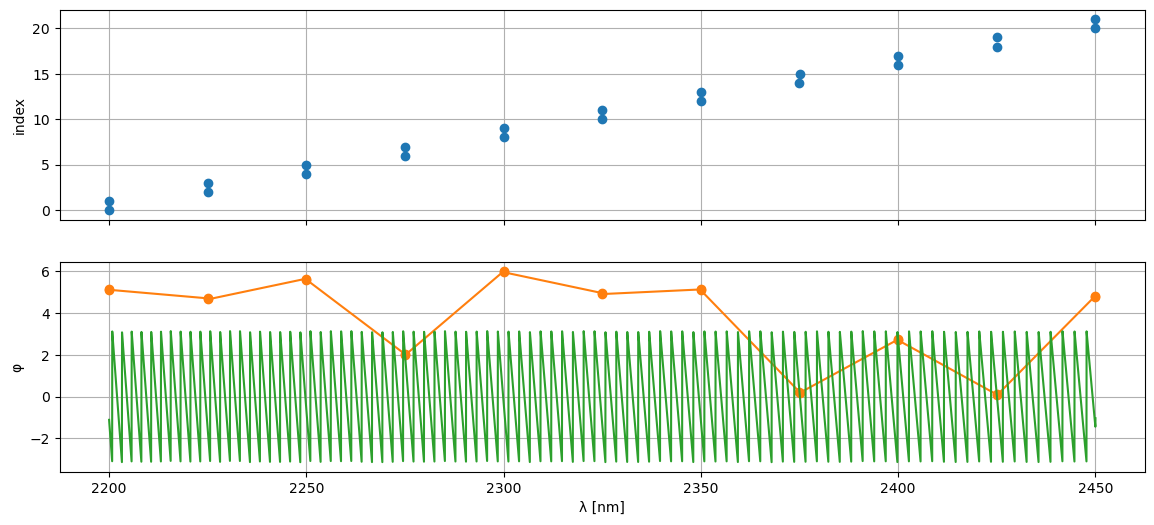

In [23]:
if JAX_AVAILABLE:
    wl = jnp.linspace(wls.min(), wls.max(), 10000)

    _, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
    plt.sca(ax[0])
    plt.plot(1e3*wls, jnp.arange(wls.shape[0]), marker="o", ls="none")
    plt.grid(True)
    plt.ylabel("index")
    plt.sca(ax[1])
    plt.grid(True)
    plt.plot(1e3*wls, phis, marker="o", c="C1")
    plt.plot(1e3*wl, grouped_interp(wl, wls, phis), c="C2")
    plt.xlabel("λ [nm]")
    plt.ylabel("φ")
    plt.show()

:::{eval-rst}
.. autofunction:: sax.utils.merge_dicts
:::


In [24]:
def merge_dicts(*dicts: Dict) -> Dict:
    """merge (possibly deeply nested) dictionaries"""
    if len(dicts) == 1:
        return dict(_generate_merged_dict(dicts[0], {}))
    elif len(dicts) == 2:
        return dict(_generate_merged_dict(dicts[0], dicts[1]))
    else:
        return merge_dicts(dicts[0], merge_dicts(*dicts[1:]))
    

def _generate_merged_dict(dict1: Dict, dict2: Dict) -> Iterator[Tuple[Any, Any]]:
    # inspired by https://stackoverflow.com/questions/7204805/how-to-merge-dictionaries-of-dictionaries
    keys = {**{k: None for k in dict1}, **{k: None for k in dict2}} # keep key order, values irrelevant
    for k in keys:
        if k in dict1 and k in dict2:
            v1, v2 = dict1[k], dict2[k]
            if isinstance(v1, dict) and isinstance(v2, dict):
                v = dict(_generate_merged_dict(v1, v2))
            else:
                # If one of the values is not a dict, you can't continue merging it.
                # Value from second dict overrides one in first and we move on.
                v = v2
        elif k in dict1:
            v = dict1[k]
        else: # k in dict2:
            v = dict2[k]
        
        if isinstance(v, dict):
            yield (k, {**v}) # shallow copy of dict
        else:
            yield (k, v)

In [25]:
d = merge_dicts({"a": 3}, {"b": 4})
assert d["a"] == 3
assert d["b"] == 4
assert tuple(sorted(d)) == ("a", "b")

d = merge_dicts({"a": 3}, {"a": 4})
assert d["a"] == 4
assert tuple(d) == ("a",)

d = merge_dicts({"a": 3}, {"a": {"b": 5}})
assert d["a"]["b"] == 5
assert tuple(d) == ("a",)

d = merge_dicts({"a": {"b": 5}}, {"a": 3})
assert d["a"] == 3
assert tuple(d) == ("a",)

:::{eval-rst}
.. autofunction:: sax.utils.mode_combinations
:::


In [26]:

def mode_combinations(
    modes: Iterable[str], cross: bool = False
) -> Tuple[Tuple[str, str], ...]:
    """create mode combinations for a collection of given modes"""
    if cross:
        mode_combinations = natsorted((m1, m2) for m1 in modes for m2 in modes)
    else:
        mode_combinations = natsorted((m, m) for m in modes)
    return tuple(mode_combinations)

In [27]:
assert mode_combinations(modes=["te", "tm"]) == (('te', 'te'), ('tm', 'tm'))
assert mode_combinations(modes=["te", "tm"], cross=True) == (('te', 'te'), ('te', 'tm'), ('tm', 'te'), ('tm', 'tm'))

:::{eval-rst}
.. autofunction:: sax.utils.reciprocal
:::


In [28]:
def reciprocal(sdict: SDict) -> SDict:
    """Make an SDict reciprocal"""
    if is_sdict(sdict):
        return {
            **{(p1, p2): v for (p1, p2), v in sdict.items()},
            **{(p2, p1): v for (p1, p2), v in sdict.items()},
        }
    else:
        raise ValueError("sax.reciprocal is only valid for SDict types")

In [29]:
sdict_ = {("in0", "out0"): 1.0}
assert reciprocal(sdict_) == {("in0", "out0"): 1.0, ("out0", "in0"): 1.0}

In [30]:

@overload
def rename_params(model: ModelFactory, renamings: Dict[str, str]) -> ModelFactory:
    ...


@overload
def rename_params(model: Model, renamings: Dict[str, str]) -> Model:
    ...

:::{eval-rst}
.. autofunction:: sax.utils.rename_params
:::


In [31]:
def rename_params(
    model: Union[Model, ModelFactory], renamings: Dict[str, str]
) -> Union[Model, ModelFactory]:
    """rename the parameters of a `Model` or `ModelFactory` given a renamings mapping old parameter names to new."""
    
    reversed_renamings = {v: k for k, v in renamings.items()}
    if len(reversed_renamings) < len(renamings):
        raise ValueError("Multiple old names point to the same new name!")

    if is_model_factory(model):
        old_model_factory = cast(ModelFactory, model)
        old_settings = get_settings(model)

        @wraps(old_model_factory)
        def new_model_factory(**settings):
            old_settings = {
                reversed_renamings.get(k, k): v for k, v in settings.items()
            }
            model = old_model_factory(**old_settings)
            return rename_params(model, renamings)

        new_settings = {renamings.get(k, k): v for k, v in old_settings.items()}
        _replace_kwargs(new_model_factory, **new_settings)

        return new_model_factory

    elif is_model(model):
        old_model = cast(Model, model)
        old_settings = get_settings(model)

        @wraps(old_model)
        def new_model(**settings):
            old_settings = {
                reversed_renamings.get(k, k): v for k, v in settings.items()
            }
            return old_model(**old_settings)

        new_settings = {renamings.get(k, k): v for k, v in old_settings.items()}
        _replace_kwargs(new_model, **new_settings)

        return new_model

    else:
        raise ValueError(
            "rename_params should be used to decorate a Model or ModelFactory."
        )
        
def _replace_kwargs(func: Callable, **kwargs: ComplexFloat):
    """Change the kwargs signature of a function"""
    sig = inspect.signature(func)
    settings = [
        inspect.Parameter(k, inspect.Parameter.KEYWORD_ONLY, default=v)
        for k, v in kwargs.items()
    ]
    func.__signature__ = sig.replace(parameters=settings)

In [32]:
def model(x=jnp.array(3.0), y=jnp.array(4.0), z=jnp.array([3.0, 4.0])) -> SDict:
    return {("in0", "out0"): jnp.array(3.0)}

renamings = {"x": "a", "y": "z", "z": "y"}
new_model = rename_params(model, renamings)
settings = get_settings(new_model)
assert settings["a"] == 3.0
assert settings["z"] == 4.0
assert jnp.all(settings["y"] == jnp.array([3.0, 4.0]))

In [33]:

@overload
def rename_ports(S: SDict, renamings: Dict[str, str]) -> SDict:
    ...


@overload
def rename_ports(S: SCoo, renamings: Dict[str, str]) -> SCoo:
    ...


@overload
def rename_ports(S: SDense, renamings: Dict[str, str]) -> SDense:
    ...


@overload
def rename_ports(S: Model, renamings: Dict[str, str]) -> Model:
    ...


@overload
def rename_ports(S: ModelFactory, renamings: Dict[str, str]) -> ModelFactory:
    ...

:::{eval-rst}
.. autofunction:: sax.utils.rename_ports
:::


In [34]:

def rename_ports(
    S: Union[SType, Model, ModelFactory], renamings: Dict[str, str]
) -> Union[SType, Model, ModelFactory]:
    """rename the ports of an `SDict`, `Model` or `ModelFactory` given a renamings mapping old port names to new."""
    if is_scoo(S):
        Si, Sj, Sx, ports_map = cast(SCoo, S)
        ports_map = {renamings[p]: i for p, i in ports_map.items()}
        return Si, Sj, Sx, ports_map
    elif is_sdense(S):
        Sx, ports_map = cast(SDense, S)
        ports_map = {renamings[p]: i for p, i in ports_map.items()}
        return Sx, ports_map
    elif is_sdict(S):
        sdict = cast(SDict, S)
        original_ports = get_ports(sdict)
        assert len(renamings) == len(original_ports)
        return {(renamings[p1], renamings[p2]): v for (p1, p2), v in sdict.items()}
    elif is_model(S):
        old_model = cast(Model, S)

        @wraps(old_model)
        def new_model(**settings) -> SType:
            return rename_ports(old_model(**settings), renamings)

        return new_model
    elif is_model_factory(S):
        old_model_factory = cast(ModelFactory, S)

        @wraps(old_model_factory)
        def new_model_factory(**settings) -> Callable[..., SType]:
            return rename_ports(old_model_factory(**settings), renamings)

        return new_model_factory
    else:
        raise ValueError("Cannot rename ports for type {type(S)}")

In [35]:
d = reciprocal({("p0", "p1"): 0.1, ("p1", "p2"): 0.2})
origports = get_ports(d)
renamings = {"p0": "in0", "p1": "out0", "p2": "in1"}
d_ = rename_ports(d, renamings)
assert tuple(sorted(get_ports(d_))) == tuple(sorted(renamings[p] for p in origports))
d_ = rename_ports(scoo(d), renamings)
assert tuple(sorted(get_ports(d_))) == tuple(sorted(renamings[p] for p in origports))
d_ = rename_ports(sdense(d), renamings)
assert tuple(sorted(get_ports(d_))) == tuple(sorted(renamings[p] for p in origports))

:::{eval-rst}
.. autofunction:: sax.utils.update_settings
:::


In [36]:

def update_settings(
    settings: Settings, *compnames: str, **kwargs: ComplexFloat
) -> Settings:
    """update a nested settings dictionary"""
    _settings = {}
    if not compnames:
        for k, v in settings.items():
            if isinstance(v, dict):
                _settings[k] = update_settings(v, **kwargs)
            else:
                if k in kwargs:
                    _settings[k] = try_float(kwargs[k])
                else:
                    _settings[k] = try_float(v)
    else:
        for k, v in settings.items():
            if isinstance(v, dict):
                if k == compnames[0]:
                    _settings[k] = update_settings(v, *compnames[1:], **kwargs)
                else:
                    _settings[k] = v
            else:
                _settings[k] = try_float(v)
    return _settings

> Note: (1) Even though it's possible to update parameter dictionaries in place, this function is convenient to apply certain parameters (e.g. wavelength 'wl' or temperature 'T') globally. (2) This operation never updates the given settings dictionary inplace. (3) Any non-float keyword arguments will be silently ignored.

Assuming you have a settings dictionary for a `circuit` containing a directional coupler `"dc"` and a waveguide `"wg"`:

In [37]:
settings = {"wl": 1.55, "dc": {"coupling": 0.5}, "wg": {"wl": 1.56, "neff": 2.33}}

You can update this settings dictionary with some global settings as follows. When updating settings globally like this, each subdictionary of the settings dictionary will be updated with these values (if the key exists in the subdictionary):

In [38]:
settings = update_settings(settings, wl=1.3, coupling=0.3, neff=3.0)
assert settings == {"wl": 1.3, "dc": {"coupling": 0.3}, "wg": {"wl": 1.3, "neff": 3.0}}

Alternatively, you can set certain settings for a specific component (e.g. 'wg' in this case) as follows:

In [39]:
settings = update_settings(settings, "wg", wl=2.0)
assert settings == {"wl": 1.3, "dc": {"coupling": 0.3}, "wg": {"wl": 2.0, "neff": 3.0}}

note that only the `"wl"` belonging to `"wg"` has changed.

:::{eval-rst}
.. autofunction:: sax.utils.validate_not_mixedmode
:::


In [40]:
def validate_not_mixedmode(S: SType):
    """validate that an stype is not 'mixed mode' (i.e. invalid)

    Args:
        S: the stype to validate
    """

    if is_mixedmode(S):  # mixed mode
        raise ValueError(
            "Given SType is neither multimode or singlemode. Please check the port "
            "names: they should either ALL contain the '@' separator (multimode) "
            "or NONE should contain the '@' separator (singlemode)."
        )

In [41]:
sdict = {("in0", "out0"): 1.0, ("out0", "in0"): 1.0}
validate_not_mixedmode(sdict)

sdict = {("in0@te", "out0@te"): 1.0, ("out0@tm", "in0@tm"): 1.0}
validate_not_mixedmode(sdict)

sdict = {("in0@te", "out0@te"): 1.0, ("out0", "in0@tm"): 1.0}
with raises(ValueError):
    validate_not_mixedmode(sdict)

:::{eval-rst}
.. autofunction:: sax.utils.validate_multimode
:::


In [42]:
def validate_multimode(S: SType, modes=("te", "tm")) -> None:
    """validate that an stype is multimode and that the given modes are present."""
    try:
        current_modes = set(p.split("@")[1] for p in get_ports(S))
    except IndexError:
        raise ValueError("The given stype is not multimode.")
    for mode in modes:
        if mode not in current_modes:
            raise ValueError(
                f"Could not find mode '{mode}' in one of the multimode models."
            )

In [43]:
sdict = {("in0", "out0"): 1.0, ("out0", "in0"): 1.0}
with raises(ValueError):
    validate_multimode(sdict)

sdict = {("in0@te", "out0@te"): 1.0, ("out0@tm", "in0@tm"): 1.0}
validate_multimode(sdict)

sdict = {("in0@te", "out0@te"): 1.0, ("out0", "in0@tm"): 1.0}
with raises(ValueError):
    validate_multimode(sdict)

:::{eval-rst}
.. autofunction:: sax.utils.validate_sdict
:::


In [44]:
def validate_sdict(sdict: Any) -> None:
    """Validate an `SDict`"""
    
    if not isinstance(sdict, dict):
        raise ValueError("An SDict should be a dictionary.")
    for ports in sdict:
        if not isinstance(ports, tuple) and not len(ports) == 2:
            raise ValueError(f"SDict keys should be length-2 tuples. Got {ports}")
        p1, p2 = ports
        if not isinstance(p1, str) or not isinstance(p2, str):
            raise ValueError(
                f"SDict ports should be strings. Got {ports} "
                f"({type(ports[0])}, {type(ports[1])})"
            )

In [45]:
good_sdict = reciprocal({("p0", "p1"): 0.1, 
                         ("p1", "p2"): 0.2})
assert validate_sdict(good_sdict) is None

bad_sdict = {
    "p0,p1": 0.1,
    ("p1", "p2"): 0.2,
}
with raises(ValueError):
    validate_sdict(bad_sdict)

:::{eval-rst}
.. autofunction:: sax.utils.get_inputs_outputs
:::


In [46]:

def get_inputs_outputs(ports: Tuple[str, ...]):
    inputs = tuple(p for p in ports if p.lower().startswith("in"))
    outputs = tuple(p for p in ports if not p.lower().startswith("in"))
    if not inputs:
        inputs = tuple(p for p in ports if not p.lower().startswith("out"))
        outputs = tuple(p for p in ports if p.lower().startswith("out"))
    return inputs, outputs

In [47]:
assert get_inputs_outputs(["in0", "out0"]) == (('in0',), ('out0',))
assert get_inputs_outputs(["in0", "in1"]) == (('in0', 'in1'), ())
assert get_inputs_outputs(["out0", "out1"]) == ((), ('out0', 'out1'))
assert get_inputs_outputs(["out0", "dc0"]) == (('dc0',), ('out0',))
assert get_inputs_outputs(["dc0", "in0"]) == (('in0',), ('dc0',))

:::{eval-rst}
.. autofunction:: sax.utils.hash_dict
:::


In [48]:

def hash_dict(dic: Dict) -> int:
    return int(
        md5(
            orjson.dumps(_numpyfy(dic), option=orjson.OPT_SERIALIZE_NUMPY | orjson.OPT_SORT_KEYS)
        ).hexdigest(),
        16,
    )

def _numpyfy(obj: Any):
    if not isinstance(obj, dict):
        return np.asarray(obj)
    else:
        return {k: _numpyfy(v) for k, v in obj.items()}